In [1]:
!git clone https://github.com/iikka-v/ML-NDT.git


Cloning into 'ML-NDT'...
remote: Enumerating objects: 632, done.
remote: Total 632 (delta 0), reused 0 (delta 0), pack-reused 632 (from 1)
Receiving objects: 100% (632/632), 174.01 MiB | 31.12 MiB/s, done.
Resolving deltas: 100% (358/358), done.
Updating files: 100% (809/809), done.


In [ ]:
with open("/content/ML-NDT/data/training/ECBB9678-7C28-4393-960B-9239AB1E0CEB.meta") as f:
    print(f.read())


UInt16, 256 x 256 x 10



In [2]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import glob

DATA_DIR = "/content/ML-NDT/data/training"



def load_ndt_sample(base_path):
    # --- Read meta ---
    with open(base_path + ".meta", "r") as f:
        meta_text = f.read().strip().replace(",", "")
        parts = meta_text.split()
        dtype_str = parts[0]
        dims = [int(x) for x in parts if x.isdigit()]

    dtype = np.uint16 if "UInt16" in dtype_str else np.uint8
    shape = tuple(dims[::-1])


    if shape != (100, 256, 256):
        return None, None


    with open(base_path + ".bins", "rb") as f:
        raw = np.frombuffer(f.read(), dtype=dtype)
    data = raw.reshape(shape)
    data = data.astype(np.float32) / np.iinfo(dtype).max


    with open(base_path + ".labels", "r") as f:
        vals = [float(v) for v in f.readline().strip().split("\t")]

    return data, vals



class NDTDataset(Dataset):
    def __init__(self, data_dir):

        all_bins = [f[:-5] for f in glob.glob(os.path.join(data_dir, "*.bins"))]
        self.files = []
        for base in all_bins:
            with open(base + ".meta", "r") as f:
                meta_text = f.read().strip().replace(",", "")
                dims = [int(x) for x in meta_text.split() if x.isdigit()]
                if tuple(dims[::-1]) == (100, 256, 256):
                    self.files.append(base)
        print(f"✅ Found {len(self.files)} valid samples with shape (100,256,256)")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        base = self.files[idx]
        data, label = load_ndt_sample(base)

        x = torch.tensor(data, dtype=torch.float32)
        y = torch.tensor(label, dtype=torch.float32)
        return x, y



batch_size = 8
dataset = NDTDataset(DATA_DIR)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)



for i, (x, y) in enumerate(loader):
    print(f"Batch {i+1}")
    print("Input shape:", x.shape)
    print("Labels:", y)
    if i == 1:
        break


✅ Found 198 valid samples with shape (100,256,256)
Batch 1
Input shape: torch.Size([8, 100, 256, 256])
Labels: tensor([[1.0000, 5.9718],
        [1.0000, 7.5243],
        [1.0000, 1.0099],
        [1.0000, 1.0432],
        [0.0000, 0.0000],
        [1.0000, 0.9980],
        [1.0000, 1.1207],
        [1.0000, 5.0778]])
Batch 2
Input shape: torch.Size([8, 100, 256, 256])
Labels: tensor([[1.0000, 4.7334],
        [0.0000, 0.0000],
        [1.0000, 6.8749],
        [0.0000, 0.0000],
        [1.0000, 1.0480],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [1.0000, 1.3976]])


Sample shape: torch.Size([100, 256, 256])
Label: tensor([1.0000, 1.1602])


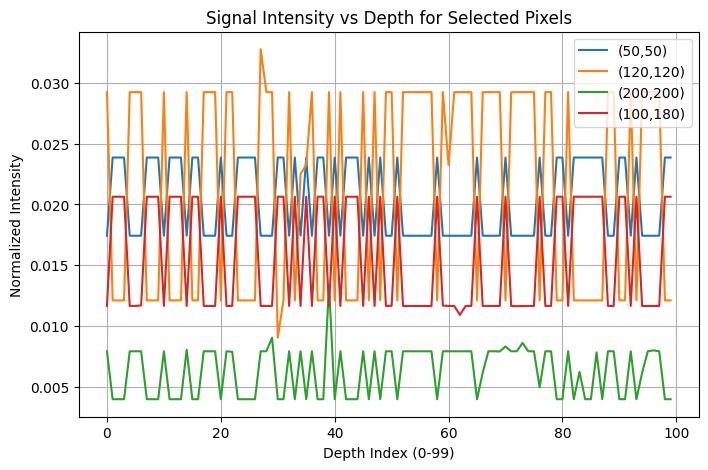

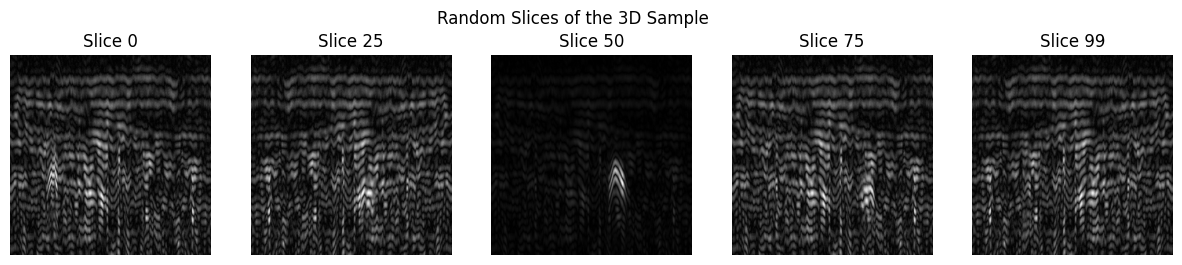

In [4]:
import matplotlib.pyplot as plt
import numpy as np


sample, label = dataset[0]
print("Sample shape:", sample.shape)
print("Label:", label)


data = sample.numpy()


points = [(50, 50), (120, 120), (200, 200), (100, 180)]

plt.figure(figsize=(8, 5))
for (x, y) in points:
    plt.plot(data[:, x, y], label=f"({x},{y})")

plt.title("Signal Intensity vs Depth for Selected Pixels")
plt.xlabel("Depth Index (0-99)")
plt.ylabel("Normalized Intensity")
plt.legend()
plt.grid(True)
plt.show()


depth_indices = [0, 25, 50, 75, 99]
plt.figure(figsize=(15, 3))
for i, d in enumerate(depth_indices):
    plt.subplot(1, len(depth_indices), i+1)
    plt.imshow(data[d], cmap='gray')
    plt.title(f"Slice {d}")
    plt.axis("off")

plt.suptitle("Random Slices of the 3D Sample")
plt.show()


In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm


DATA_DIR = "/content/ML-NDT/data/training"
CHECKPOINT_PATH = "/content/ndt_checkpoint.pth"
EPOCHS = 50
LR = 1e-4
BATCH_SIZE = 4


def normalize(volume):
    volume = (volume - volume.min()) / (volume.max() - volume.min() + 1e-8)
    return volume



full_dataset = NDTDataset(DATA_DIR)
print(f"✅ Found {len(full_dataset)} valid samples")

train_size = int(0.9 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)



class NDT3DNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv3d(1, 16, 3, padding=1), nn.BatchNorm3d(16), nn.ReLU(),
            nn.Conv3d(16, 32, 3, padding=1), nn.BatchNorm3d(32), nn.ReLU(),
            nn.MaxPool3d(2),

            nn.Conv3d(32, 64, 3, padding=1), nn.BatchNorm3d(64), nn.ReLU(),
            nn.Conv3d(64, 128, 3, padding=1), nn.BatchNorm3d(128), nn.ReLU(),
            nn.MaxPool3d(2),

            nn.Conv3d(128, 256, 3, padding=1), nn.BatchNorm3d(256), nn.ReLU(),
            nn.Conv3d(256, 512, 3, padding=1), nn.BatchNorm3d(512), nn.ReLU(),
            nn.AdaptiveAvgPool3d(1)
        )
        self.dropout = nn.Dropout(0.4)
        self.classifier = nn.Linear(512, 1)
        self.regressor = nn.Linear(512, 1)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)

        return self.classifier(x), self.regressor(x)



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NDT3DNet().to(device)
criterion_class = nn.BCEWithLogitsLoss()
criterion_reg = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
scaler = torch.amp.GradScaler("cuda")

start_epoch = 0


if os.path.exists(CHECKPOINT_PATH):
    print(f"🔁 Found old checkpoint at {CHECKPOINT_PATH}, attempting partial load...")
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
    try:
        model.load_state_dict(checkpoint["model_state"], strict=False)
        optimizer.load_state_dict(checkpoint["optimizer_state"])
        start_epoch = checkpoint["epoch"] + 1
        print(f"✅ Loaded compatible weights, resuming from epoch {start_epoch}")
    except Exception as e:
        print("⚠️ Could not fully load checkpoint, starting fresh due to model size mismatch.")
        print(e)
else:
    print("🚀 Starting new training run")



for epoch in range(start_epoch, EPOCHS):
    model.train()
    total_loss, total_class_loss, total_reg_loss = 0, 0, 0
    correct, total = 0, 0

    for data, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        data, labels = data.to(device).float(), labels.to(device).float()
        data = normalize(data).unsqueeze(1)

        class_label = labels[:, 0].unsqueeze(1)
        reg_label = labels[:, 1].unsqueeze(1)

        optimizer.zero_grad()

        with torch.amp.autocast("cuda"):
            class_out, reg_out = model(data)
            loss_class = criterion_class(class_out, class_label)
            loss_reg = criterion_reg(reg_out, reg_label)
            loss = loss_class + 0.2 * loss_reg

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        total_class_loss += loss_class.item()
        total_reg_loss += loss_reg.item()


        preds = (torch.sigmoid(class_out) > 0.5).float()
        correct += (preds == class_label).sum().item()
        total += class_label.numel()

    train_acc = correct / total
    print(f"📘 Epoch {epoch+1}/{EPOCHS} | TrainAcc: {train_acc*100:.2f}% | TotalLoss: {total_loss:.4f}")

    scheduler.step(total_loss)


    torch.save({
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
    }, CHECKPOINT_PATH)
    print(f"💾 Saved checkpoint at epoch {epoch+1}")



model.eval()
correct, total = 0, 0
mse_total = 0

with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device).float(), labels.to(device).float()
        data = normalize(data).unsqueeze(1)
        class_label = labels[:, 0].unsqueeze(1)
        reg_label = labels[:, 1].unsqueeze(1)

        class_out, reg_out = model(data)
        preds = (torch.sigmoid(class_out) > 0.5).float()
        correct += (preds == class_label).sum().item()
        total += class_label.numel()
        mse_total += F.mse_loss(reg_out, reg_label, reduction="sum").item()

acc = correct / total
mse = mse_total / total
print(f"\n✅ Test Accuracy: {acc*100:.2f}%")
print(f"📏 Test MSE (Flaw size): {mse:.6f}")


✅ Found 198 valid samples with shape (100,256,256)
✅ Found 198 valid samples
🚀 Starting new training run


Epoch 1/50: 100%|██████████| 45/45 [01:14<00:00,  1.65s/it]


📘 Epoch 1/50 | TrainAcc: 56.18% | TotalLoss: 100.4744
💾 Saved checkpoint at epoch 1


Epoch 2/50: 100%|██████████| 45/45 [01:15<00:00,  1.68s/it]


📘 Epoch 2/50 | TrainAcc: 58.43% | TotalLoss: 91.5505
💾 Saved checkpoint at epoch 2


Epoch 3/50: 100%|██████████| 45/45 [01:15<00:00,  1.68s/it]


📘 Epoch 3/50 | TrainAcc: 60.67% | TotalLoss: 89.6062
💾 Saved checkpoint at epoch 3


Epoch 4/50: 100%|██████████| 45/45 [01:16<00:00,  1.69s/it]


📘 Epoch 4/50 | TrainAcc: 60.67% | TotalLoss: 92.7227
💾 Saved checkpoint at epoch 4


Epoch 5/50: 100%|██████████| 45/45 [01:15<00:00,  1.68s/it]


📘 Epoch 5/50 | TrainAcc: 58.43% | TotalLoss: 91.3810
💾 Saved checkpoint at epoch 5


Epoch 6/50: 100%|██████████| 45/45 [01:15<00:00,  1.69s/it]


📘 Epoch 6/50 | TrainAcc: 60.11% | TotalLoss: 88.1353
💾 Saved checkpoint at epoch 6


Epoch 7/50: 100%|██████████| 45/45 [01:16<00:00,  1.69s/it]


📘 Epoch 7/50 | TrainAcc: 57.87% | TotalLoss: 91.1790
💾 Saved checkpoint at epoch 7


Epoch 8/50: 100%|██████████| 45/45 [01:15<00:00,  1.68s/it]


📘 Epoch 8/50 | TrainAcc: 58.99% | TotalLoss: 92.4192
💾 Saved checkpoint at epoch 8


Epoch 9/50: 100%|██████████| 45/45 [01:15<00:00,  1.68s/it]


📘 Epoch 9/50 | TrainAcc: 60.11% | TotalLoss: 89.4755
💾 Saved checkpoint at epoch 9


Epoch 10/50: 100%|██████████| 45/45 [01:15<00:00,  1.69s/it]


📘 Epoch 10/50 | TrainAcc: 57.87% | TotalLoss: 88.8514
💾 Saved checkpoint at epoch 10


Epoch 11/50: 100%|██████████| 45/45 [01:16<00:00,  1.69s/it]


📘 Epoch 11/50 | TrainAcc: 61.24% | TotalLoss: 85.5562
💾 Saved checkpoint at epoch 11


Epoch 12/50: 100%|██████████| 45/45 [01:16<00:00,  1.69s/it]


📘 Epoch 12/50 | TrainAcc: 57.87% | TotalLoss: 87.1691
💾 Saved checkpoint at epoch 12


Epoch 13/50: 100%|██████████| 45/45 [01:16<00:00,  1.69s/it]


📘 Epoch 13/50 | TrainAcc: 63.48% | TotalLoss: 84.8383
💾 Saved checkpoint at epoch 13


Epoch 14/50: 100%|██████████| 45/45 [01:16<00:00,  1.70s/it]


📘 Epoch 14/50 | TrainAcc: 60.67% | TotalLoss: 85.3816
💾 Saved checkpoint at epoch 14


Epoch 15/50: 100%|██████████| 45/45 [01:16<00:00,  1.70s/it]


📘 Epoch 15/50 | TrainAcc: 65.17% | TotalLoss: 84.0987
💾 Saved checkpoint at epoch 15


Epoch 16/50: 100%|██████████| 45/45 [01:16<00:00,  1.70s/it]


📘 Epoch 16/50 | TrainAcc: 60.67% | TotalLoss: 82.8455
💾 Saved checkpoint at epoch 16


Epoch 17/50: 100%|██████████| 45/45 [01:16<00:00,  1.70s/it]


📘 Epoch 17/50 | TrainAcc: 63.48% | TotalLoss: 80.0847
💾 Saved checkpoint at epoch 17


Epoch 18/50: 100%|██████████| 45/45 [01:16<00:00,  1.70s/it]


📘 Epoch 18/50 | TrainAcc: 65.73% | TotalLoss: 74.2911
💾 Saved checkpoint at epoch 18


Epoch 19/50: 100%|██████████| 45/45 [01:16<00:00,  1.70s/it]


📘 Epoch 19/50 | TrainAcc: 67.98% | TotalLoss: 71.6726
💾 Saved checkpoint at epoch 19


Epoch 20/50: 100%|██████████| 45/45 [01:16<00:00,  1.69s/it]


📘 Epoch 20/50 | TrainAcc: 66.85% | TotalLoss: 76.5476
💾 Saved checkpoint at epoch 20


Epoch 21/50: 100%|██████████| 45/45 [01:16<00:00,  1.70s/it]


📘 Epoch 21/50 | TrainAcc: 67.98% | TotalLoss: 70.3423
💾 Saved checkpoint at epoch 21


Epoch 22/50: 100%|██████████| 45/45 [01:16<00:00,  1.70s/it]


📘 Epoch 22/50 | TrainAcc: 71.35% | TotalLoss: 69.1901
💾 Saved checkpoint at epoch 22


Epoch 23/50: 100%|██████████| 45/45 [01:16<00:00,  1.70s/it]


📘 Epoch 23/50 | TrainAcc: 70.79% | TotalLoss: 67.8827
💾 Saved checkpoint at epoch 23


Epoch 24/50: 100%|██████████| 45/45 [01:16<00:00,  1.70s/it]


📘 Epoch 24/50 | TrainAcc: 79.21% | TotalLoss: 60.9763
💾 Saved checkpoint at epoch 24


Epoch 25/50: 100%|██████████| 45/45 [01:16<00:00,  1.71s/it]


📘 Epoch 25/50 | TrainAcc: 72.47% | TotalLoss: 66.9251
💾 Saved checkpoint at epoch 25


Epoch 26/50: 100%|██████████| 45/45 [01:16<00:00,  1.70s/it]


📘 Epoch 26/50 | TrainAcc: 78.65% | TotalLoss: 58.6734
💾 Saved checkpoint at epoch 26


Epoch 27/50: 100%|██████████| 45/45 [01:16<00:00,  1.70s/it]


📘 Epoch 27/50 | TrainAcc: 75.28% | TotalLoss: 55.6213
💾 Saved checkpoint at epoch 27


Epoch 28/50: 100%|██████████| 45/45 [01:16<00:00,  1.70s/it]


📘 Epoch 28/50 | TrainAcc: 82.02% | TotalLoss: 56.5320
💾 Saved checkpoint at epoch 28


Epoch 29/50: 100%|██████████| 45/45 [01:16<00:00,  1.70s/it]


📘 Epoch 29/50 | TrainAcc: 78.65% | TotalLoss: 55.7520
💾 Saved checkpoint at epoch 29


Epoch 30/50: 100%|██████████| 45/45 [01:16<00:00,  1.71s/it]


📘 Epoch 30/50 | TrainAcc: 79.21% | TotalLoss: 57.5184
💾 Saved checkpoint at epoch 30


Epoch 31/50: 100%|██████████| 45/45 [01:16<00:00,  1.70s/it]


📘 Epoch 31/50 | TrainAcc: 80.90% | TotalLoss: 49.7107
💾 Saved checkpoint at epoch 31


Epoch 32/50: 100%|██████████| 45/45 [01:16<00:00,  1.70s/it]


📘 Epoch 32/50 | TrainAcc: 85.39% | TotalLoss: 47.7806
💾 Saved checkpoint at epoch 32


Epoch 33/50: 100%|██████████| 45/45 [01:16<00:00,  1.70s/it]


📘 Epoch 33/50 | TrainAcc: 79.21% | TotalLoss: 50.6298
💾 Saved checkpoint at epoch 33


Epoch 34/50: 100%|██████████| 45/45 [01:16<00:00,  1.70s/it]


📘 Epoch 34/50 | TrainAcc: 82.02% | TotalLoss: 46.1296
💾 Saved checkpoint at epoch 34


Epoch 35/50: 100%|██████████| 45/45 [01:16<00:00,  1.70s/it]


📘 Epoch 35/50 | TrainAcc: 82.58% | TotalLoss: 45.8964
💾 Saved checkpoint at epoch 35


Epoch 36/50: 100%|██████████| 45/45 [01:16<00:00,  1.70s/it]


📘 Epoch 36/50 | TrainAcc: 83.71% | TotalLoss: 40.9642
💾 Saved checkpoint at epoch 36


Epoch 37/50: 100%|██████████| 45/45 [01:16<00:00,  1.69s/it]


📘 Epoch 37/50 | TrainAcc: 81.46% | TotalLoss: 40.6776
💾 Saved checkpoint at epoch 37


Epoch 38/50: 100%|██████████| 45/45 [01:16<00:00,  1.70s/it]


📘 Epoch 38/50 | TrainAcc: 88.20% | TotalLoss: 37.9171
💾 Saved checkpoint at epoch 38


Epoch 39/50: 100%|██████████| 45/45 [01:16<00:00,  1.69s/it]


📘 Epoch 39/50 | TrainAcc: 85.96% | TotalLoss: 33.7621
💾 Saved checkpoint at epoch 39


Epoch 40/50: 100%|██████████| 45/45 [01:16<00:00,  1.70s/it]


📘 Epoch 40/50 | TrainAcc: 83.71% | TotalLoss: 50.0227
💾 Saved checkpoint at epoch 40


Epoch 41/50: 100%|██████████| 45/45 [01:16<00:00,  1.69s/it]


📘 Epoch 41/50 | TrainAcc: 90.45% | TotalLoss: 38.0457
💾 Saved checkpoint at epoch 41


Epoch 42/50: 100%|██████████| 45/45 [01:16<00:00,  1.70s/it]


📘 Epoch 42/50 | TrainAcc: 89.33% | TotalLoss: 35.9393
💾 Saved checkpoint at epoch 42


Epoch 43/50: 100%|██████████| 45/45 [01:16<00:00,  1.70s/it]


📘 Epoch 43/50 | TrainAcc: 85.96% | TotalLoss: 43.1064
💾 Saved checkpoint at epoch 43


Epoch 44/50: 100%|██████████| 45/45 [01:16<00:00,  1.70s/it]


📘 Epoch 44/50 | TrainAcc: 91.57% | TotalLoss: 30.4397
💾 Saved checkpoint at epoch 44


Epoch 45/50: 100%|██████████| 45/45 [01:16<00:00,  1.70s/it]


📘 Epoch 45/50 | TrainAcc: 90.45% | TotalLoss: 32.1603
💾 Saved checkpoint at epoch 45


Epoch 46/50: 100%|██████████| 45/45 [01:16<00:00,  1.70s/it]


📘 Epoch 46/50 | TrainAcc: 90.45% | TotalLoss: 33.2252
💾 Saved checkpoint at epoch 46


Epoch 47/50: 100%|██████████| 45/45 [01:16<00:00,  1.70s/it]


📘 Epoch 47/50 | TrainAcc: 89.33% | TotalLoss: 35.4388
💾 Saved checkpoint at epoch 47


Epoch 48/50: 100%|██████████| 45/45 [01:16<00:00,  1.69s/it]


📘 Epoch 48/50 | TrainAcc: 93.26% | TotalLoss: 27.5351
💾 Saved checkpoint at epoch 48


Epoch 49/50: 100%|██████████| 45/45 [01:16<00:00,  1.70s/it]


📘 Epoch 49/50 | TrainAcc: 94.94% | TotalLoss: 24.5616
💾 Saved checkpoint at epoch 49


Epoch 50/50: 100%|██████████| 45/45 [01:16<00:00,  1.70s/it]


📘 Epoch 50/50 | TrainAcc: 92.70% | TotalLoss: 32.7458
💾 Saved checkpoint at epoch 50

✅ Test Accuracy: 65.00%
📏 Test MSE (Flaw size): 17.030379
